# Production (2021-07-22)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from radar.data import load
from radar.processing import signal_intensity
from scipy.signal import detrend

import matplotlib
matplotlib.rc('font', size=16)

## Calibration parameters

In [2]:
C_H, C_V = 2.5245361120845994e-06, 4.010945224807307e-06 # see calibration.ipynb for details

In [3]:
Phi_H, Phi_V = np.deg2rad(4.8), np.deg2rad(4.5) # one-way, full beam widths

In [4]:
theta_i = np.deg2rad(18.4) # incidence angle
h = 1.52 - 0.8 # heigh of the antenna above mean water level
d = h / np.sin(theta_i) # distance from target
d # m

2.2810144043641105

In [5]:
A = np.pi / 4 * Phi_H * Phi_V * d**2 / np.cos(theta_i) # illuminated area
A

0.028336418361637302

In [6]:
def normalized_radar_cross_section(power, range, area, calibration_constant):
    return calibration_constant * power * range**4 / area


def get_sigma_for_run(path):
    """Returns time, sigma_HH, and sigma_VV for the whole run."""
    C_H, C_V = 2.5245361120845994e-06, 4.010945224807307e-06 # see calibration.ipynb for details
    
    time, ref, Hpol, Vpol = load(path)
    
    num_samples, num_records = ref.shape

    difftime = np.diff(time)
    
    # specially handle this run where the time record had a glitch
    if 'radar_25Hz_20210722-191919.h5' in path:
        time[2032:] += (time[2031] - time[2032])
        
    dt = np.diff(time).mean()
    time = np.linspace(time[0], time[-1] + dt, num_samples * num_records, endpoint=True)
    
    rho_h = signal_intensity(Hpol.real, Hpol.imag).flatten()
    rho_v = signal_intensity(Vpol.real, Vpol.imag).flatten()
    rho_ref = signal_intensity(ref.real, ref.imag).flatten()
    rho_h_norm = rho_h / rho_ref
    rho_v_norm = rho_v / rho_ref
    
    sigma_HH = normalized_radar_cross_section(rho_h / rho_ref, d, A, C_H)
    sigma_VV = normalized_radar_cross_section(rho_v / rho_ref, d, A, C_V)
    
    return time, sigma_HH, sigma_VV

In [7]:
path = 'data/production/20210722'
filenames = glob.glob(path + '/radar_*.h5')
filenames.sort()
filenames

['data/production/20210722/radar_15Hz_20210722-185102.h5',
 'data/production/20210722/radar_20Hz_20210722-190447.h5',
 'data/production/20210722/radar_25Hz_20210722-191919.h5',
 'data/production/20210722/radar_30Hz_20210722-193355.h5',
 'data/production/20210722/radar_35Hz_20210722-194627.h5']

In [8]:
fan = [15, 20, 25, 30, 35]

In [9]:
time = []
sigma_HH = []
sigma_VV = []

for n, path in enumerate(filenames):
    print('Calculating normalized radar cross section for run ' + str(fan[n]))
    t, s_HH, s_VV = get_sigma_for_run(path)
    time.append(t)
    sigma_HH.append(s_HH)
    sigma_VV.append(s_VV)

Calculating normalized radar cross section for run 15
Calculating normalized radar cross section for run 20
Calculating normalized radar cross section for run 25
Calculating normalized radar cross section for run 30
Calculating normalized radar cross section for run 35


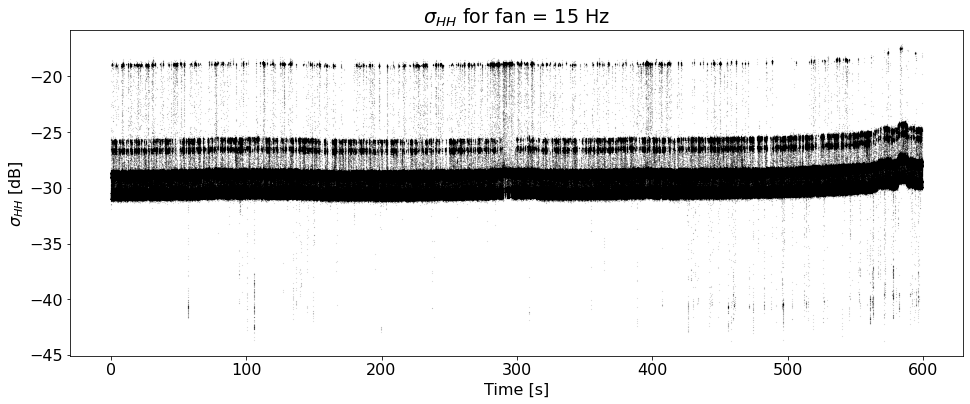

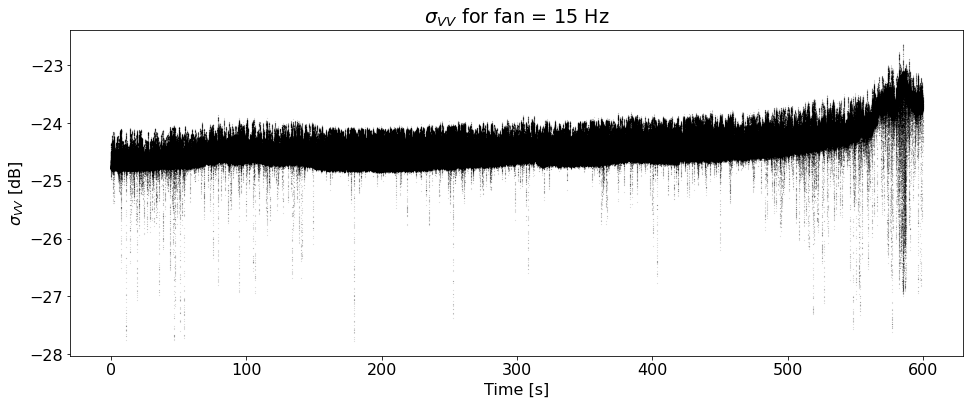

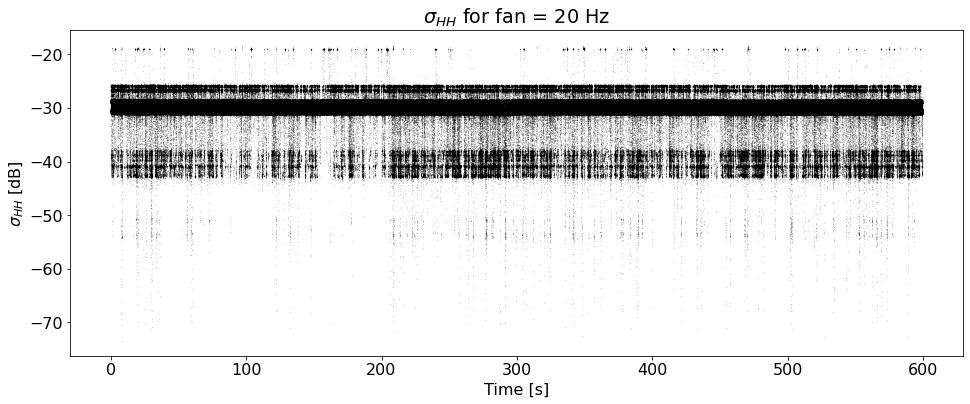

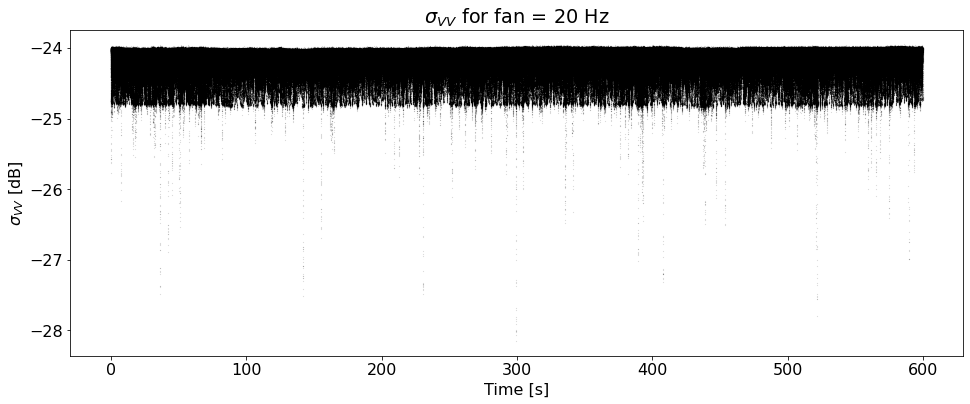

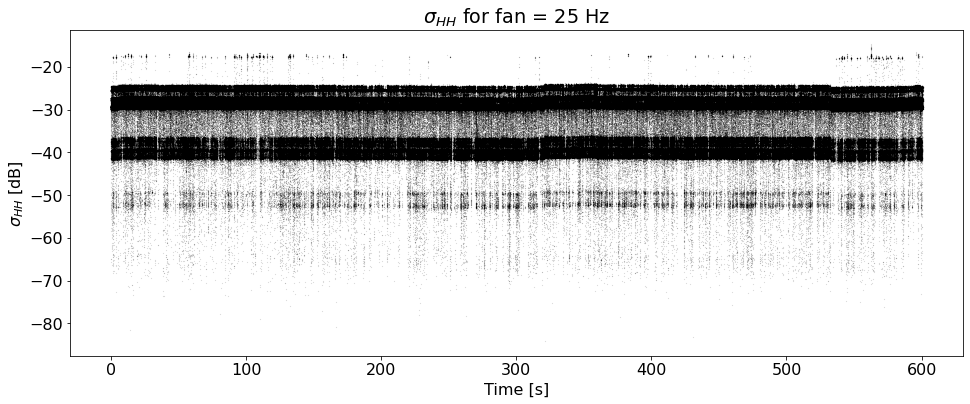

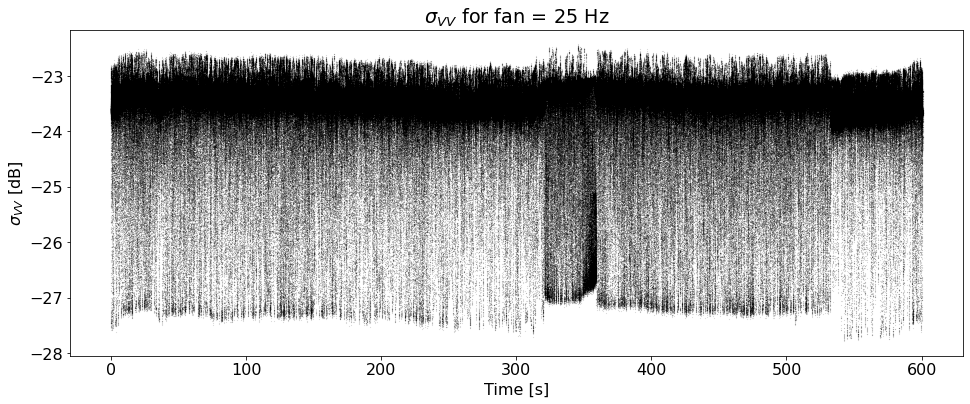

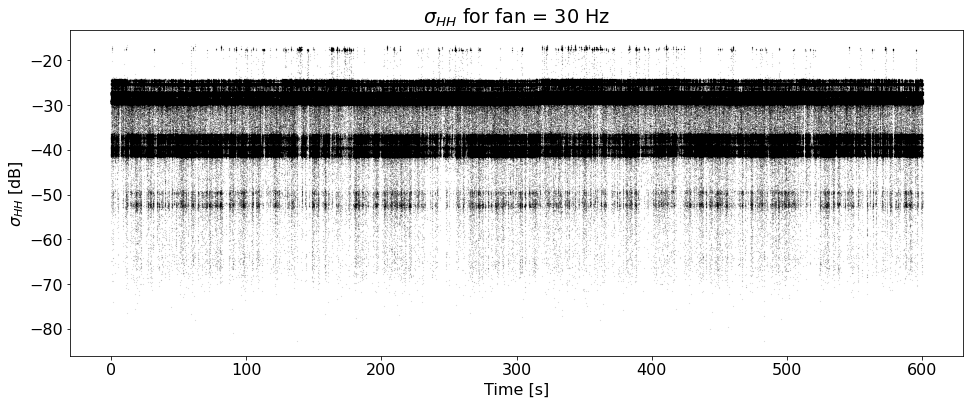

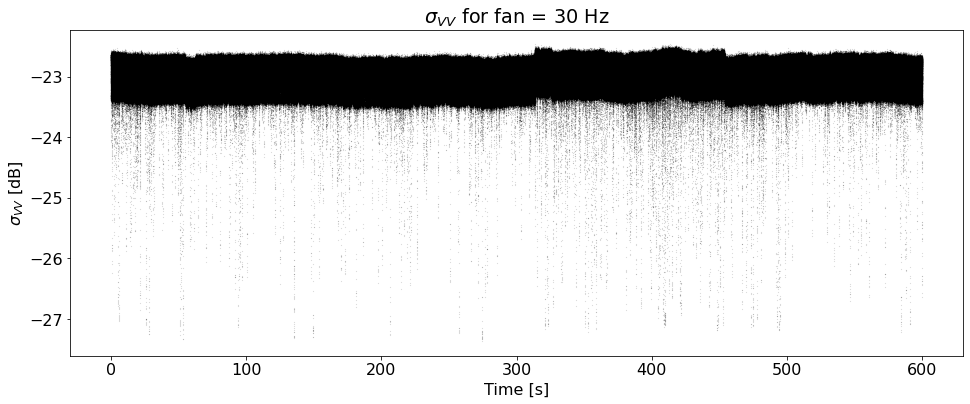

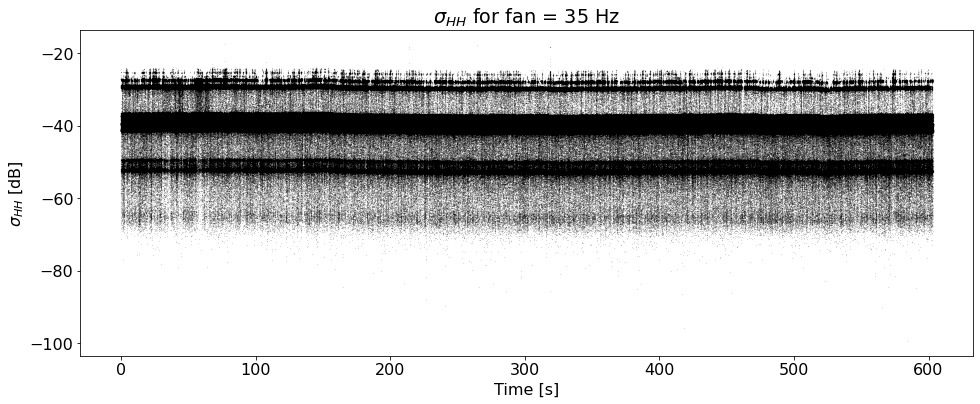

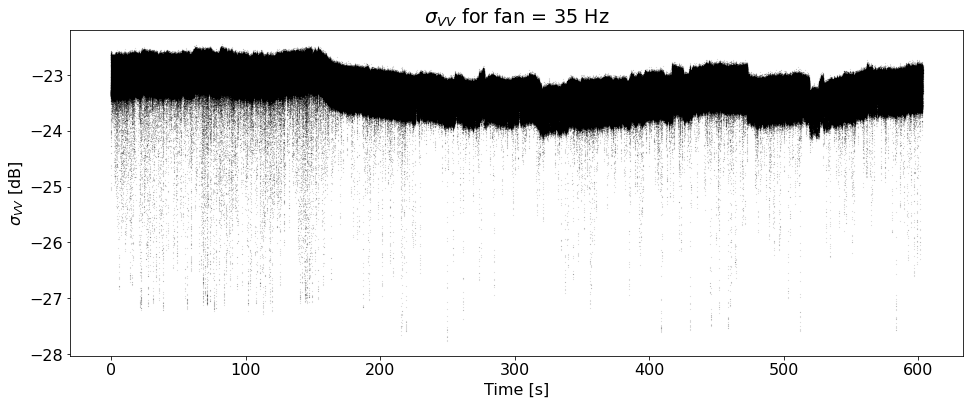

In [10]:
for n, fan_speed in enumerate(fan):

    fig = plt.figure(figsize=(16, 6))
    plt.plot(time[n], 10 * np.log10(sigma_HH[n]), 'k.', ms=0.1)
    plt.xlabel('Time [s]')
    plt.ylabel(r'$\sigma_{HH}$ [dB]')
    plt.title(r'$\sigma_{HH}$ for fan = %i Hz' % fan_speed)
    plt.show()

    fig = plt.figure(figsize=(16, 6))
    plt.plot(time[n], 10 * np.log10(sigma_VV[n]), 'k.', ms=0.1)
    plt.xlabel('Time [s]')
    plt.ylabel(r'$\sigma_{VV}$ [dB]')
    plt.title(r'$\sigma_{VV}$ for fan = %i Hz' % fan_speed)
    plt.show()

## Zoom in on a 5-s segment

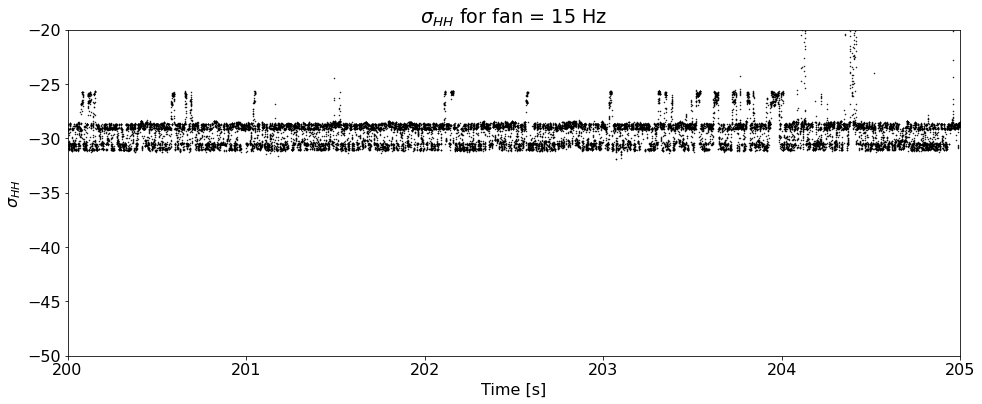

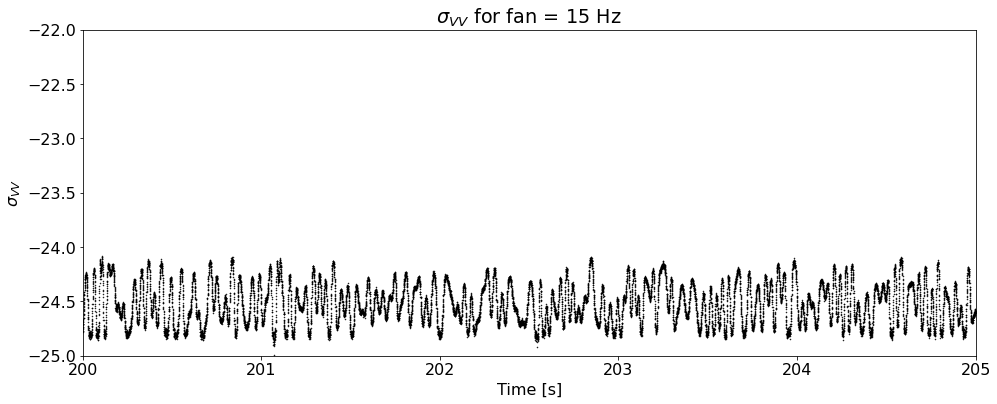

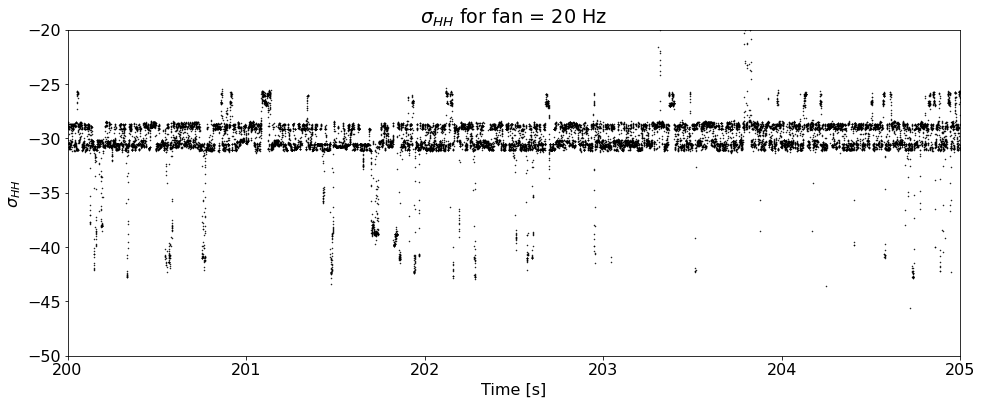

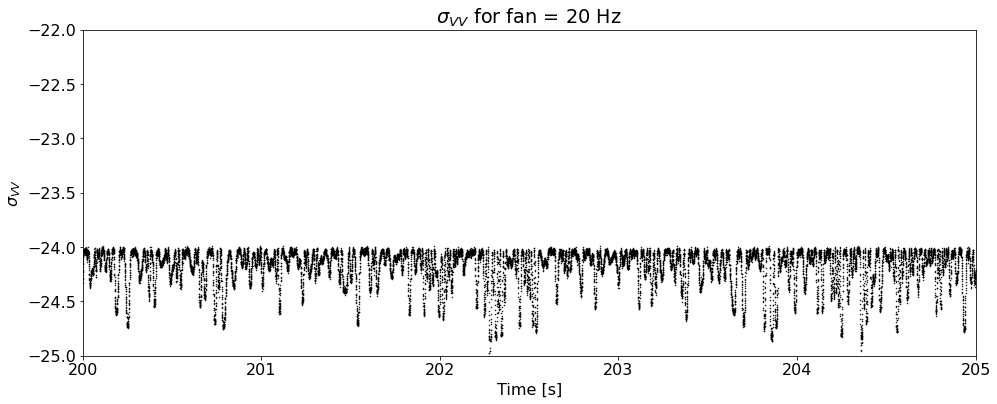

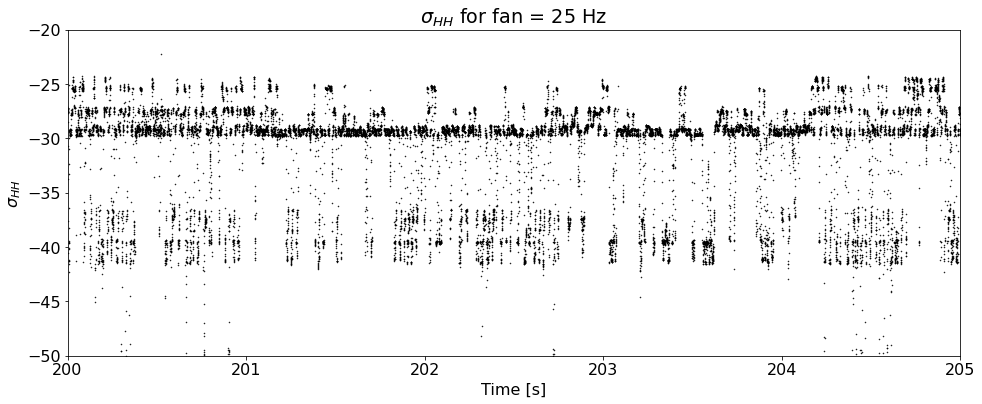

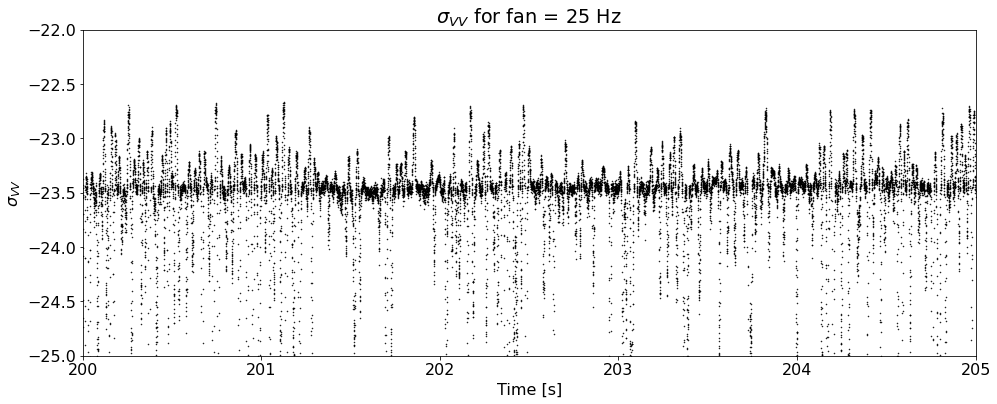

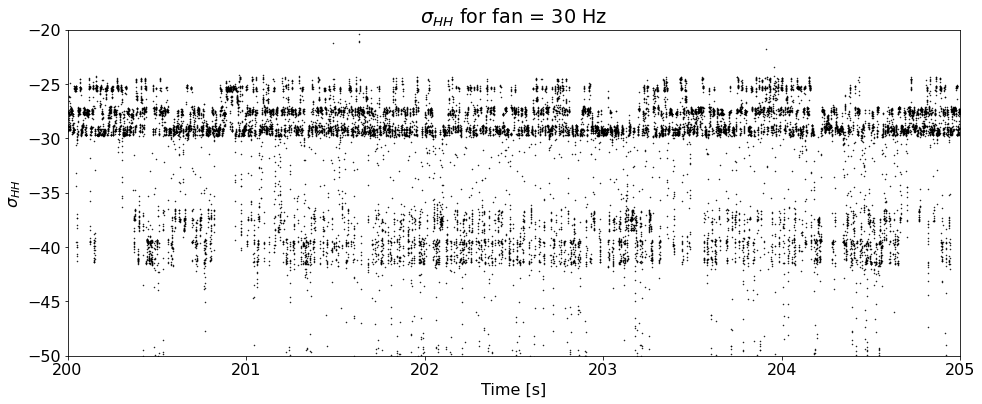

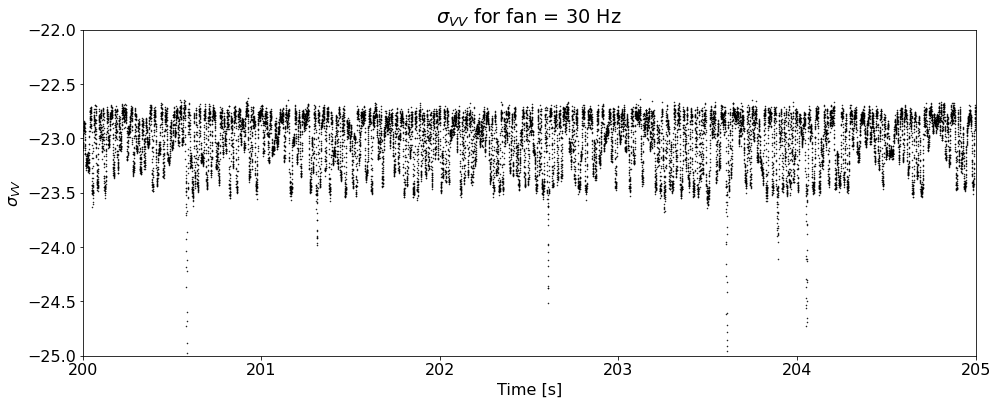

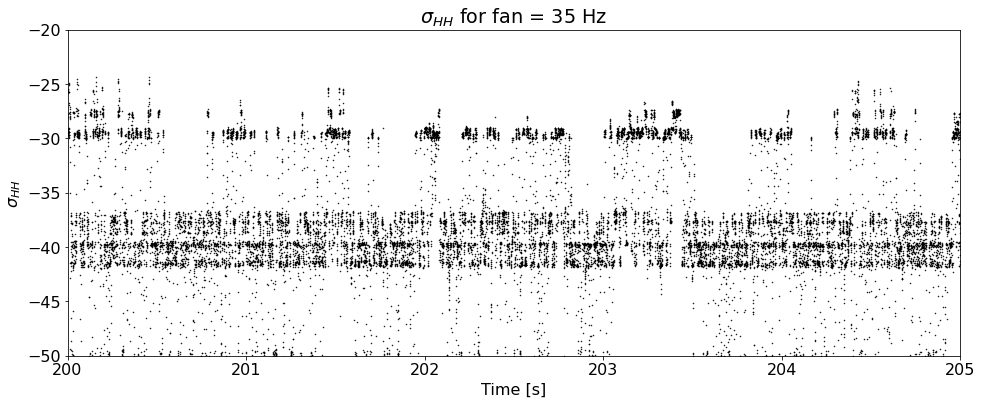

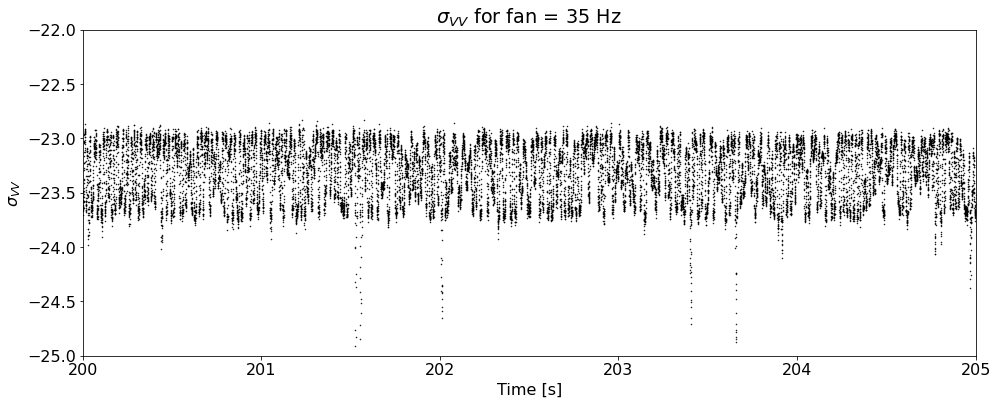

In [11]:
for n, fan_speed in enumerate(fan):

    fig = plt.figure(figsize=(16, 6))
    plt.plot(time[n], 10 * np.log10(sigma_HH[n]), 'k.', ms=1)
    plt.xlabel('Time [s]')
    plt.ylabel(r'$\sigma_{HH}$')
    plt.title(r'$\sigma_{HH}$ for fan = %i Hz' % fan_speed)
    plt.xlim(200, 205)
    plt.ylim(-50, -20)
    plt.show()

    fig = plt.figure(figsize=(16, 6))
    plt.plot(time[n], 10 * np.log10(sigma_VV[n]), 'k.', ms=1)
    plt.xlabel('Time [s]')
    plt.ylabel(r'$\sigma_{VV}$')
    plt.title(r'$\sigma_{VV}$ for fan = %i Hz' % fan_speed)
    plt.xlim(200, 205)
    plt.ylim(-25, -22)
    plt.show()